Dataset có Target gồm 3 giá trị: Dropout / Graduate / Enrolled.

- Train (có nhãn): chỉ dùng Dropout + Graduate → bài toán nhị phân label (1 = Dropout, 0 = Graduate).

- Deploy (chưa nhãn tương lai): nhóm Enrolled → dùng mô hình đã train để dự đoán xác suất dropout p_dropout.

- Vì Enrolled chưa biết tương lai nên dùng validation gián tiếp: xem nhóm Enrolled “nguy cơ cao” có đặc điểm giống Dropout thật hay không.

### Thư viện - Cell 1

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
roc_auc_score, average_precision_score,
classification_report, confusion_matrix,
RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.base import clone
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Chỉnh cột csv.
do 36 cột bị dồn lại thành 1 cột nên sẽ tách ra

In [ ]:
# path = "/content/drive/MyDrive/NCKH_US/data.csv.xlsx"
# out_dir  = "/content/drive/MyDrive/NCKH_US"
# os.makedirs(out_dir, exist_ok=True)
# raw = pd.read_excel(path)

# headers = [h.strip().strip('"').replace('\t','').strip()
#            for h in raw.columns[0].split(';')]

# split = raw.iloc[:, 0].astype(str).str.split(';', expand=True)
# split.columns = headers
# split.head()
# for c in split.columns:
#     split[c] = pd.to_numeric(split[c], errors="ignore")

# out_xlsx = os.path.join(out_dir, "data_clean.xlsx")
# out_csv  = os.path.join(out_dir, "data_clean.csv")

# split.to_excel(out_xlsx, index=False)
# split.to_csv(out_csv, index=False)

# print("Saved to:")
# print(out_xlsx)
# print(out_csv)

/tmp/ipython-input-3271548257.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  split[c] = pd.to_numeric(split[c], errors="ignore")


Saved to:
/content/drive/MyDrive/NCKH_US/data_clean.xlsx
/content/drive/MyDrive/NCKH_US/data_clean.csv


### Mở file data.csv nếu đã làm SẠCH - Cell 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/NCKH_US/data_clean.csv"
df = pd.read_csv(DATA_PATH)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Kiểm tra cột Target (Graduate - Dropout - Enrolled) - Cell 3

In [3]:
print('Has Target:', 'Target' in df.columns)
print(df['Target'].value_counts(dropna=False) if 'Target' in df.columns else 'No Target column')

Has Target: True
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


### Tách tập Train (Graduate/Dropout) và Deploy (Enrolled) - Cell 4

In [4]:
assert 'Target' in df.columns, "Dataset must have the Target Column (Graduate/Dropout/Enrolled)."
TARGET_COL = "Target"

train_df = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
deploy_df = df[df['Target'] == 'Enrolled'].copy()
train_df["label"] = train_df[TARGET_COL].map({"Graduate": 0, "Dropout": 1}).astype(int)

print("Train size:", train_df.shape, "| Deploy(Enrolled) size:", deploy_df.shape)
print(train_df[TARGET_COL].value_counts())

Train size: (3630, 38) | Deploy(Enrolled) size: (794, 37)
Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64


### EDA - Cell 5

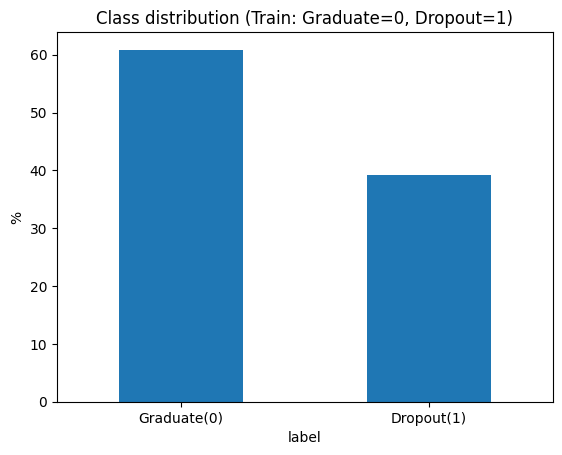

In [5]:
ax = train_df["label"].value_counts(normalize=True).sort_index().mul(100).plot(kind='bar')
ax.set_title("Class distribution (Train: Graduate=0, Dropout=1)")
ax.set_ylabel("%")
ax.set_xticklabels(["Graduate(0)", "Dropout(1)"], rotation=0)
plt.show()

### Xây pipeline tiền xử lý + mô hình - Cell 6

In [6]:
FEATURE_COLS = [
    c for c in train_df.columns
      if c not in [TARGET_COL, "label"]]

X = train_df[FEATURE_COLS].copy()
y = train_df["label"].copy()

known_categorical = [
    "Marital status",
    "Application mode",
    "Course",
    "Daytime/evening attendance",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
]

binary_cols = [c for c in X.columns if X[c].nunique(dropna=False) == 2]

force_numeric = {
    "Application order",
    "Age at enrollment",
    "Admission grade",
    "Previous qualification (grade)",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
}

categorical_cols = [c for c in known_categorical if c in X.columns]

def is_count_or_grade(col: str) -> bool:
    if "Curricular units" in col:
        return True
    if "grade" in col:
        return True
    return False

auto_cat = []
for c in X.columns:
    if c in categorical_cols:
        continue
    if c in binary_cols:
        continue
    if c in force_numeric:
        continue
    if is_count_or_grade(c):
        continue
    if pd.api.types.is_integer_dtype(X[c]) and 3 <= X[c].nunique() <= 30:
        auto_cat.append(c)

categorical_cols = sorted(set(categorical_cols + auto_cat))

numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))
print("Example categorical:", categorical_cols[:15])
print("Course in categorical?", "Course" in categorical_cols)

# Pipeline xử lý
numeric_transformer = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
  ],
  remainder='drop'
)

Numeric cols: 26
Categorical cols: 10
Example categorical: ['Application mode', 'Course', 'Daytime/evening attendance', "Father's occupation", "Father's qualification", 'Marital status', "Mother's occupation", "Mother's qualification", 'Nacionality', 'Previous qualification']
Course in categorical? True


### Chia train/test và train 3 mô hình: - Cell 7
Logistic Regression;
Random Forest;
XGBoost

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression
lr_model = Pipeline(steps=[
  ("preprocess", preprocess),
  ("clf", LogisticRegression(max_iter=4000, n_jobs=None, class_weight=None))
])
# Random Forest
rf_model = Pipeline(steps=[
  ("preprocess", preprocess),
  ("clf", RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2,
    class_weight=None
    ))
  ])
#XGBoost
boost_name = "XGBoost"
boost_model = Pipeline(steps=[
  ("preprocess", preprocess),
  ("clf", XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
  ))
])
models = {
  "Logistic": lr_model,
  "RandomForest": rf_model,
}
if boost_model is not None:
  models[boost_name] = boost_model
# Train
for name, model in models.items():
  model.fit(X_train, y_train)
  proba = model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, proba)
  ap = average_precision_score(y_test, proba)
  print(f"{name}: ROC-AUC={auc:.4f} | PR-AUC(AP)={ap:.4f}")

Logistic: ROC-AUC=0.9760 | PR-AUC(AP)=0.9735
RandomForest: ROC-AUC=0.9719 | PR-AUC(AP)=0.9683
XGBoost: ROC-AUC=0.9725 | PR-AUC(AP)=0.9708



_____ Logistic _____
ROC-AUC: 0.9760
PR-AUC (AP): 0.9735
Confusion matrix [ [TN FP] [FN TP] ]:
 [[415  27]
 [ 23 261]]

Classification report:
               precision    recall  f1-score   support

           0     0.9475    0.9389    0.9432       442
           1     0.9062    0.9190    0.9126       284

    accuracy                         0.9311       726
   macro avg     0.9269    0.9290    0.9279       726
weighted avg     0.9314    0.9311    0.9312       726



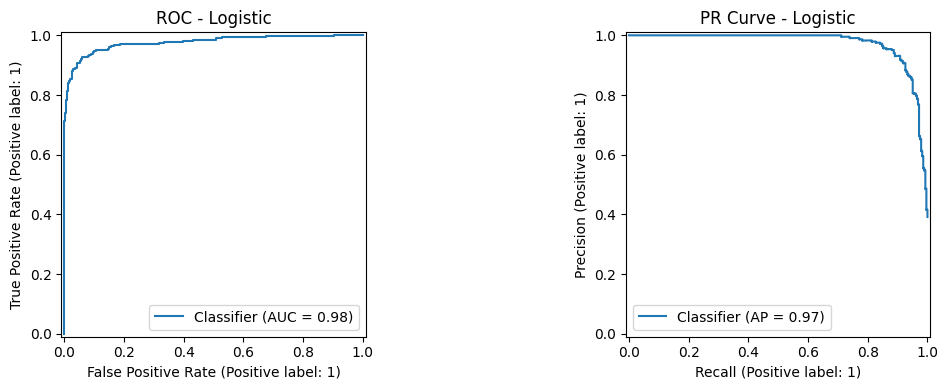


_____ RandomForest _____
ROC-AUC: 0.9719
PR-AUC (AP): 0.9683
Confusion matrix [ [TN FP] [FN TP] ]:
 [[426  16]
 [ 34 250]]

Classification report:
               precision    recall  f1-score   support

           0     0.9261    0.9638    0.9446       442
           1     0.9398    0.8803    0.9091       284

    accuracy                         0.9311       726
   macro avg     0.9330    0.9220    0.9268       726
weighted avg     0.9315    0.9311    0.9307       726



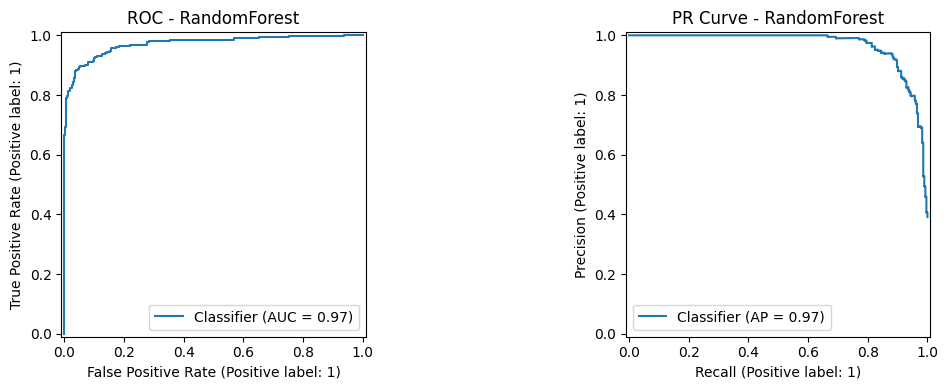


_____ XGBoost _____
ROC-AUC: 0.9725
PR-AUC (AP): 0.9708
Confusion matrix [ [TN FP] [FN TP] ]:
 [[408  34]
 [ 28 256]]

Classification report:
               precision    recall  f1-score   support

           0     0.9358    0.9231    0.9294       442
           1     0.8828    0.9014    0.8920       284

    accuracy                         0.9146       726
   macro avg     0.9093    0.9122    0.9107       726
weighted avg     0.9150    0.9146    0.9148       726



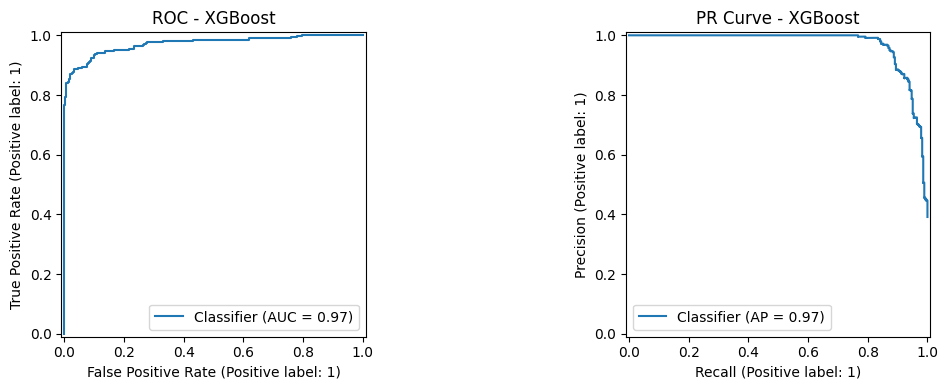

In [8]:
def evaluate_model(name: str, model: Pipeline, X_te, y_te, threshold: float = 0.5):
    proba = model.predict_proba(X_te)[:, 1]
    pred = (proba >= threshold).astype(int)

    auc = roc_auc_score(y_te, proba)
    ap  = average_precision_score(y_te, proba)
    cm  = confusion_matrix(y_te, pred)

    print(f"\n_____ {name} _____")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"PR-AUC (AP): {ap:.4f}")
    print("Confusion matrix [ [TN FP] [FN TP] ]:\n", cm)
    print("\nClassification report:\n", classification_report(y_te, pred, digits=4))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    RocCurveDisplay.from_predictions(y_te, proba, ax=axes[0])
    axes[0].set_title(f"ROC - {name}")

    PrecisionRecallDisplay.from_predictions(y_te, proba, ax=axes[1])
    axes[1].set_title(f"PR Curve - {name}")

    plt.tight_layout()
    plt.show()

    return {"auc": auc, "ap": ap, "cm": cm, "proba": proba}
results = {}
for name, model in models.items():
    results[name] = evaluate_model(name, model, X_test, y_test, threshold=0.5)


### Chọn mô hình - Cell 8

In [9]:
summary = pd.DataFrame({
k: {"roc_auc": v["auc"], "pr_auc": v["ap"]} for k, v in results.items()
}).T.sort_values("roc_auc", ascending=False)
summary

best_name = summary.index[0]
best_model = models[best_name]
print("Best model by ROC-AUC:", best_name)

Best model by ROC-AUC: Logistic


### Giải thích mô hình - Cell 9

Base AUC: 0.975973487986744


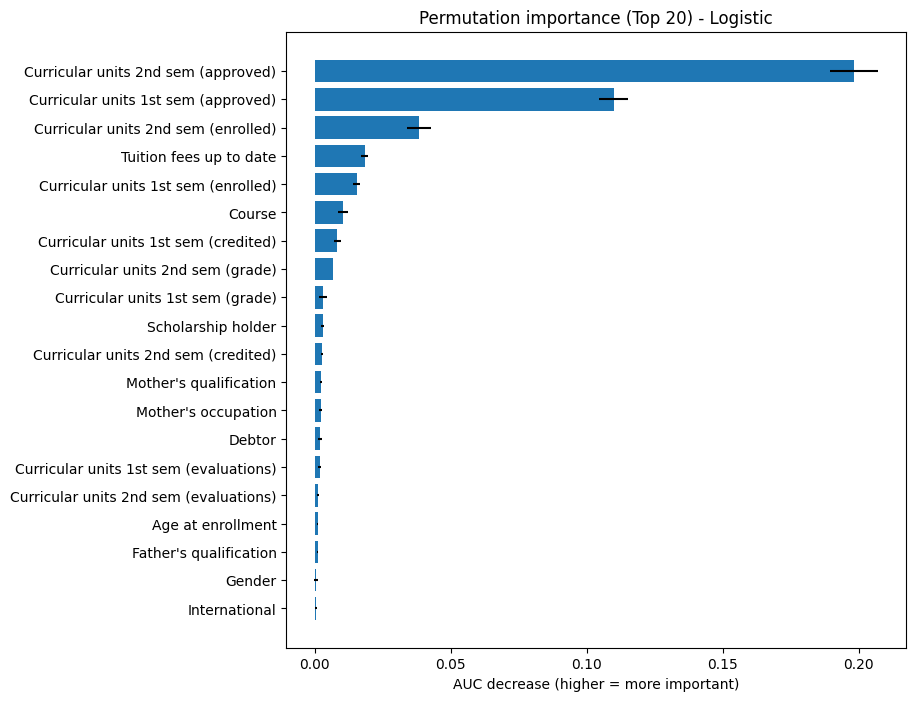

In [10]:
def permutation_importance_by_raw_columns(model: Pipeline, X_base: pd.DataFrame, y_true: pd.Series,
              n_repeats: int = 3, random_state: int = 42):
  rng = np.random.default_rng(random_state)
  base_proba = model.predict_proba(X_base)[:, 1]
  base_auc = roc_auc_score(y_true, base_proba)
  importances = []
  for col in X_base.columns:
    scores = []
    for _ in range(n_repeats):
      X_perm = X_base.copy()
      X_perm[col] = rng.permutation(X_perm[col].values)
      proba = model.predict_proba(X_perm)[:, 1]
      auc = roc_auc_score(y_true, proba)
      scores.append(base_auc - auc)
    importances.append((col, float(np.mean(scores)), float(np.std(scores))))
  imp_df = pd.DataFrame(importances, columns=["feature", "importance_mean", "importance_std"]).sort_values(
    "importance_mean", ascending=False
  )
  return base_auc, imp_df
base_auc, imp_df = permutation_importance_by_raw_columns(best_model, X_test, y_test, n_repeats=5)
print("Base AUC:", base_auc)
imp_df.head(20)
topk = 20
plot_df = imp_df.head(topk).iloc[::-1]
plt.figure(figsize=(8, 8))
plt.barh(plot_df["feature"], plot_df["importance_mean"], xerr=plot_df["importance_std"])
plt.title(f"Permutation importance (Top {topk}) - {best_name}")
plt.xlabel("AUC decrease (higher = more important)")
plt.show()

### Khung giải thích nhóm nguyên nhân - Cell 10

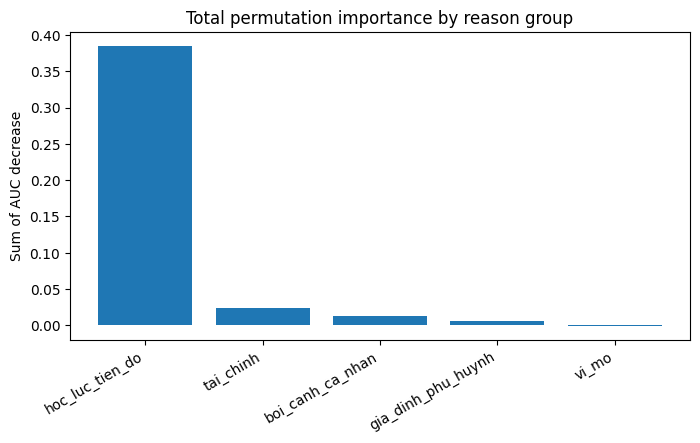

In [11]:
GROUPS = {
  "hoc_luc_tien_do": [
    "Admission grade",
    "Previous qualification (grade)",
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)",
    ],
  "tai_chinh": [
    "Debtor",
    "Tuition fees up to date",
    "Scholarship holder",
    ],
  "gia_dinh_phu_huynh": [
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    ],
  "boi_canh_ca_nhan": [
    "Age at enrollment",
    "Gender",
    "Marital status",
    "Nacionality",
    "International",
    "Displaced",
    "Educational special needs",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance",
    "Previous qualification",
    "Attendance",
    ],
  "vi_mo": [
    "GDP",
    "Inflation rate",
    "Unemployment rate",
    ],
}
imp_map = dict(zip(imp_df.feature, imp_df.importance_mean))
group_scores = []
for g, cols in GROUPS.items():
  score = sum(imp_map.get(c, 0.0) for c in cols)
  group_scores.append((g, score, len(cols)))
group_scores_df = pd.DataFrame(group_scores, columns=["group", "importance_sum", "n_features"]).sort_values(
"importance_sum", ascending=False
)
group_scores_df
plt.figure(figsize=(8, 4))
plt.bar(group_scores_df["group"], group_scores_df["importance_sum"])
plt.title("Total permutation importance by reason group")
plt.ylabel("Sum of AUC decrease")
plt.xticks(rotation=30, ha='right')
plt.show()

### Tính Dropout Rate theo từng biến - Cell 11

In [17]:
def dropout_rate_table(df_train: pd.DataFrame, var: str, label_col: str = "label") -> pd.DataFrame:
    tab = pd.crosstab(df_train[var], df_train[label_col], normalize="index")
    tab.columns = ["Graduate(0)", "Dropout(1)"]
    tab = (tab * 100).round(2)
    tab["n"] = df_train[var].value_counts().loc[tab.index].values
    return tab.sort_index()

def dropout_rate_binned(df_train: pd.DataFrame, var: str, bins, labels=None, label_col="label"):
    tmp = df_train.copy()
    new_col = var + "_bin"
    tmp[new_col] = pd.cut(tmp[var], bins=bins, labels=labels, include_lowest=True)
    return dropout_rate_table(tmp, new_col, label_col=label_col)

core_vars_fin = ["Tuition fees up to date", "Debtor"]

core_vars_acad = [
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
]

print("_____(A) Statistics by Finance group_____")
for var in core_vars_fin:
    if var in train_df.columns:
        print("\n+", var)
        display(dropout_rate_table(train_df, var))

print("\n_____(B) Statistics by Academic Performance/Progress group_____")

if "Curricular units 2nd sem (approved)" in train_df.columns:
    print("\n+ Curricular units 2nd sem (approved) (binned)")
    display(dropout_rate_binned(
        train_df,
        "Curricular units 2nd sem (approved)",
        bins=[-0.1, 0, 2, 4, 30],
        labels=["0", "1-2", "3-4", ">=5"]
    ))

# grade: Grade average in the 2nd semester (between 0 and 20) in Portugal
if "Curricular units 2nd sem (grade)" in train_df.columns:
    print("\n+ Curricular units 2nd sem (grade) (binned)")
    display(dropout_rate_binned(
    train_df,
    "Curricular units 2nd sem (grade)",
    bins=[-0.01, 9.9, 13.9, 15.9, 17.9, 20.0],
    labels=["0-9.9 Fail", "10-13.9 Satisfactory", "14-15.9 Good",
            "16-17.9 Very Good", "18-20 Excellent"]
    ))


_____(A) Statistics by Finance group_____

+ Tuition fees up to date


,Graduate(0),Dropout(1),n
Tuition fees up to date,,,
0,5.97,94.03,486
1,69.34,30.66,3144



+ Debtor


,Graduate(0),Dropout(1),n
Debtor,,,
0,65.53,34.47,3217
1,24.46,75.54,413



_____(B) Statistics by Academic Performance/Progress group_____

+ Curricular units 2nd sem (approved) (binned)


,Graduate(0),Dropout(1),n
Curricular units 2nd sem (approved)_bin,,,
0,9.35,90.65,802
1-2,2.42,97.58,207
3-4,42.41,57.59,415
>=5,88.53,11.47,2206



+ Curricular units 2nd sem (grade) (binned)


,Graduate(0),Dropout(1),n
Curricular units 2nd sem (grade)_bin,,,
0-9.9 Fail,9.35,90.65,802
10-13.9 Satisfactory,71.35,28.65,2171
14-15.9 Good,89.90,10.10,604
16-17.9 Very Good,78.85,21.15,52
18-20 Excellent,100.00,0.00,1


### Deploy dự đoán Dropout cho Enrolled

In [27]:
X_deploy = deploy_df[[c for c in FEATURE_COLS if c in deploy_df.columns]].copy()

deploy_df = deploy_df.copy()
deploy_df["p_dropout"] = best_model.predict_proba(X_deploy)[:, 1]

cut = deploy_df["p_dropout"].quantile(0.90)
highrisk_top10 = deploy_df[deploy_df["p_dropout"] >= cut].copy()

print(f"Top 10% cutoff (p_dropout) = {cut:.4f}")
print("High-risk Enrolled (top 10%) size:", highrisk_top10.shape,
      f"= {100*len(highrisk_top10)/len(deploy_df):.2f}% of Enrolled")

Top 10% cutoff (p_dropout) = 0.9647
High-risk Enrolled (top 10%) size: (80, 38) = 10.08% of Enrolled


### Validation gián tiếp
So sánh:
 - Enrolled nguy cơ cao - top 10%

Vs
- Dropout thật
- Graduate thật

In [31]:
real_dropout = train_df[train_df["label"] == 1].copy()
real_graduate = train_df[train_df["label"] == 0].copy()
compare_vars = [
  "Admission grade",
  "Age at enrollment",
  "Debtor",
  "Tuition fees up to date",
  "Scholarship holder",
  "Curricular units 1st sem (approved)",
  "Curricular units 1st sem (grade)",
  "Curricular units 2nd sem (approved)",
  "Curricular units 2nd sem (grade)",
]
compare_vars = [c for c in compare_vars if c in FEATURE_COLS]

def summarize_groups(groups: dict, vars_: list) -> pd.DataFrame:
    rows = []
    for gname, gdf in groups.items():
        row = {"group": gname, "n": len(gdf)}
        for c in vars_:
            if pd.api.types.is_numeric_dtype(gdf[c]):
                row[c] = float(np.nanmean(gdf[c]))
            else:
                row[c] = gdf[c].mode().iloc[0] if not gdf[c].mode().empty else np.nan
        rows.append(row)
    return pd.DataFrame(rows)

summary_cmp = summarize_groups({
  "Dropout(real)": real_dropout,
  "Graduate(real)": real_graduate,
  "Enrolled_highrisk_top10": highrisk_top10,
}, compare_vars)

summary_show = summary_cmp.copy()

pct_cols = ["Debtor", "Tuition fees up to date", "Scholarship holder"]
for c in pct_cols:
    if c in summary_show.columns:
        summary_show[c] = (summary_show[c] * 100).round(2)
summary_show = summary_show.rename(columns={
    "Debtor": "Debtor (%)",
    "Tuition fees up to date": "Tuition fees up to date (%)",
    "Scholarship holder": "Scholarship holder (%)",
})

summary_show

,group,n,Admission grade,Age at enrollment,Debtor (%),Tuition fees up to date (%),Scholarship holder (%),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade)
0,Dropout(real),1421,124.961365,26.068966,21.96,67.84,9.43,2.551724,7.256656,1.940183,5.899339
1,Graduate(real),2209,128.794432,21.783612,4.57,98.69,37.80,6.232232,12.643655,6.177003,12.697276
2,Enrolled_highrisk_top10,80,125.552500,23.250000,37.50,85.00,7.50,1.825000,6.872777,1.300000,5.826572


### Đo mức giống nhau giữa Enrolled high-risk và Dropout/Graduate.
- |SMD| gần 0: giống nhau
- |SMD| > 0.5: khác đáng kể
- Dấu “+”: nhóm highrisk có giá trị cao hơn nhóm so sánh
- Dấu “−”: nhóm highrisk thấp hơn nhóm so sánh

In [32]:
def smd(a: pd.Series, b: pd.Series) -> float:
  a = pd.to_numeric(a, errors='coerce')
  b = pd.to_numeric(b, errors='coerce')
  ma, mb = np.nanmean(a), np.nanmean(b)
  sa, sb = np.nanstd(a, ddof=1), np.nanstd(b, ddof=1)
  pooled = np.sqrt((sa**2 + sb**2) / 2.0)
  if pooled == 0 or np.isnan(pooled):
    return 0.0
  return float((ma - mb) / pooled)
smd_rows = []
for c in compare_vars:
  if c in FEATURE_COLS and pd.api.types.is_numeric_dtype(train_df[c]):
    smd_drop = smd(highrisk_top10[c], real_dropout[c])
    smd_grad = smd(highrisk_top10[c], real_graduate[c])
    smd_rows.append({"feature": c, "SMD(highrisk vs Dropout)": smd_drop, "SMD(highrisk vs Graduate)": smd_grad})
smd_df = pd.DataFrame(smd_rows).sort_values(by="SMD(highrisk vs Dropout)", key=lambda s: s.abs())
feature_order = [
    "Admission grade",
    "Age at enrollment",
    "Tuition fees up to date",
    "Debtor",
    "Scholarship holder",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
]
feature_order = [f for f in feature_order if f in smd_df["feature"].values]
smd_df["feature"] = pd.Categorical(smd_df["feature"], categories=feature_order, ordered=True)
smd_df = smd_df.sort_values("feature").reset_index(drop=True)
smd_df

,feature,SMD(highrisk vs Dropout),SMD(highrisk vs Graduate)
0,Admission grade,0.038952,-0.221133
1,Age at enrollment,-0.372719,0.227020
2,Tuition fees up to date,0.411720,-0.513534
3,Debtor,0.343797,0.878476
4,Scholarship holder,-0.069166,-0.775297
5,Curricular units 1st sem (approved),-0.267671,-1.712245
6,Curricular units 1st sem (grade),-0.063515,-1.230806
7,Curricular units 2nd sem (approved),-0.276647,-2.269881
8,Curricular units 2nd sem (grade),-0.012165,-1.511330
